### 5.1 Data & baseline params

Prepare the same Top-30 feature matrix and compute scale_pos_weight = (#neg / #pos) from training labels only. This keeps the validation set realistic.


In [4]:
!pip install xgboost -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.3 MB/s eta 0:00:00 MB/s eta 0:00:01


In [1]:
# Load data & prepare split 
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, log_loss,
    accuracy_score, precision_score, recall_score, f1_score
)

# 1) Load merged training data
train_path = "outputs_merged/train_merged.parquet"
df = pd.read_parquet(train_path)

print("Loaded merged train:", df.shape)
print("CTR (positive rate):", df['label'].mean())

# 2) Define target and remove non-feature columns
target = "label"
drop_cols = [
    'label', 'log_id', 'user_id', 'pt_d',       # IDs / raw time string
    # raw multi-value strings (not used in baseline)
    'ad_click_list_v001','ad_click_list_v002','ad_click_list_v003',
    'ad_close_list_v001','ad_close_list_v002','ad_close_list_v003',
    'u_newsCatInterestsST'
]

# 3) Keep numeric features only for baseline logistic
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target]   # ensure target excluded

X_all = df[numeric_cols].copy()
y_all = df[target].astype(int).copy()

print(f"Using {len(numeric_cols)} numeric features.")
print("Sample of feature columns:", numeric_cols[:10])

# 4) Stratified train/validation split to preserve class distribution
X_train, X_valid, y_train, y_valid = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

print("Train size:", X_train.shape, "Valid size:", X_valid.shape)
print("Valid CTR (positive rate):", y_valid.mean())

Loaded merged train: (7675517, 68)
CTR (positive rate): 0.01552156030662169
Using 60 numeric features.
Sample of feature columns: ['log_id', 'user_id', 'age', 'gender', 'residence', 'city', 'city_rank', 'series_dev', 'series_group', 'emui_dev']
Train size: (6140413, 60) Valid size: (1535104, 60)
Valid CTR (positive rate): 0.01552142395564079


In [3]:
# === 5.1 Prepare data & params ===
import numpy as np
import xgboost as xgb

# Safe Top-30 features (same as Notebook 4)
top_feats = [
    'creat_type_cd','f_cat_uniq','f_refresh_sum','slot_id','f_rows',
    'f_up_sum','f_dislike_sum','f_refresh_mean','u_refreshTimes',
    'u_newsCatInterestsST_len','f_up_mean','u_feedLifeCycle',
    'u_newsCatInterestsST_uniq','f_entities_len_mean','f_dislike_mean',
    'f_browser_life','adv_prim_id','device_size','adv_id','task_id',
    'inter_type_cd','hispace_app_tags','spread_app_id','app_second_class',
    'ad_click_list_v002_uniq','ad_click_list_v002_len','f_hour_cos'
]

# Build matrices from your existing split
X_tr = X_train[top_feats]
X_va = X_valid[top_feats]
y_tr = y_train.values
y_va = y_valid.values

# Compute scale_pos_weight on training only
pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
spw = neg / max(pos, 1)
print(f"Train labels -> pos={pos:,}, neg={neg:,}, scale_pos_weight={spw:.2f}")

dtrain = xgb.DMatrix(X_tr, label=y_tr, feature_names=top_feats)
dvalid = xgb.DMatrix(X_va, label=y_va, feature_names=top_feats)

# Baseline XGBoost parameters
xgb_params_base = {
    "objective": "binary:logistic",
    "eval_metric": ["aucpr", "auc", "logloss"],  # PR-AUC, ROC-AUC, LogLoss
    "learning_rate": 0.06,
    "max_depth": 8,
    "min_child_weight": 200,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,             # L2
    "alpha": 0.0,              # L1
    "scale_pos_weight": spw,   # imbalance handling
    "tree_method": "hist",
    "random_state": 42
}
print("Baseline params ready.")

Train labels -> pos=95,309, neg=6,045,104, scale_pos_weight=63.43
Baseline params ready.


### 5.2 Train baseline XGBoost (+ evaluation helper)

Train a baseline XGBoost with early stopping. Then evaluate with ROC-AUC, PR-AUC, LogLoss, and F1 at 0.50 and best-F1 thresholds. We also compute ROC/PR curves.


Train labels -> pos=95,309, neg=6,045,104, scale_pos_weight=63.43
Params ready.
[0]	train-aucpr:0.10826	train-auc:0.78433	train-logloss:0.68559	valid-aucpr:0.10414	valid-auc:0.77815	valid-logloss:0.68559
[100]	train-aucpr:0.13064	train-auc:0.81117	train-logloss:0.52182	valid-aucpr:0.12456	valid-auc:0.80085	valid-logloss:0.52272
[200]	train-aucpr:0.14171	train-auc:0.82282	train-logloss:0.50825	valid-aucpr:0.13246	valid-auc:0.80667	valid-logloss:0.50967
[300]	train-aucpr:0.14652	train-auc:0.83148	train-logloss:0.50018	valid-aucpr:0.13478	valid-auc:0.80921	valid-logloss:0.50197
[400]	train-aucpr:0.14988	train-auc:0.83846	train-logloss:0.49391	valid-aucpr:0.13612	valid-auc:0.81073	valid-logloss:0.49604
[500]	train-aucpr:0.15283	train-auc:0.84421	train-logloss:0.48860	valid-aucpr:0.13722	valid-auc:0.81172	valid-logloss:0.49102
[600]	train-aucpr:0.15540	train-auc:0.84995	train-logloss:0.48337	valid-aucpr:0.13779	valid-auc:0.81235	valid-logloss:0.48611
[700]	train-aucpr:0.15803	train-auc:0.85

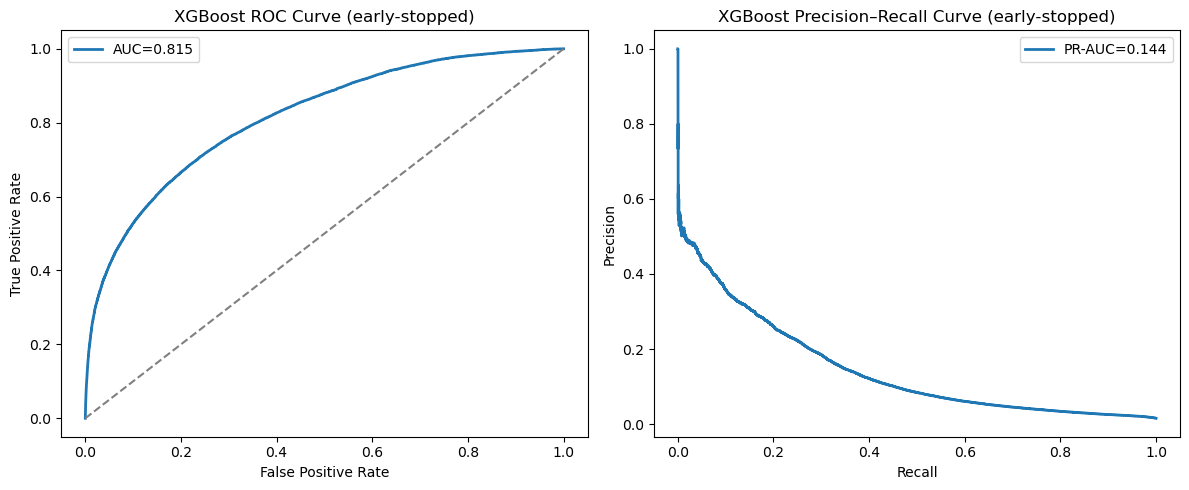

In [5]:
# === 5.x XGBoost with stronger early-stopping (stabilize valid AUC) ===
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score, log_loss,
    f1_score, precision_score, recall_score, accuracy_score,
    roc_curve, precision_recall_curve, auc, confusion_matrix
)

# --- 1) Use the same Top-30 features as before ---
top_feats = [
    'creat_type_cd','f_cat_uniq','f_refresh_sum','slot_id','f_rows',
    'f_up_sum','f_dislike_sum','f_refresh_mean','u_refreshTimes',
    'u_newsCatInterestsST_len','f_up_mean','u_feedLifeCycle',
    'u_newsCatInterestsST_uniq','f_entities_len_mean','f_dislike_mean',
    'f_browser_life','adv_prim_id','device_size','adv_id','task_id',
    'inter_type_cd','hispace_app_tags','spread_app_id','app_second_class',
    'ad_click_list_v002_uniq','ad_click_list_v002_len','f_hour_cos'
]

X_tr = X_train[top_feats]
X_va = X_valid[top_feats]
y_tr = y_train.values
y_va = y_valid.values

# --- 2) Compute imbalance ratio for scale_pos_weight ---
pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
spw = neg / max(pos, 1)
print(f"Train labels -> pos={pos:,}, neg={neg:,}, scale_pos_weight={spw:.2f}")

# --- 3) DMatrix ---
dtrain = xgb.DMatrix(X_tr, label=y_tr, feature_names=top_feats)
dvalid = xgb.DMatrix(X_va, label=y_va, feature_names=top_feats)

# --- 4) Params: smaller lr, larger min_child_weight to reduce overfitting ---
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": ["aucpr", "auc", "logloss"],
    "learning_rate": 0.03,       # ↓ slower learning to help generalization
    "max_depth": 8,
    "min_child_weight": 300,     # ↑ make splits harder (less overfit)
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "alpha": 0.0,
    "scale_pos_weight": spw,     # handle imbalance
    "tree_method": "hist",
    "random_state": 42
}
print("Params ready.")

# --- 5) Train with stronger early-stopping ---
evals_result = {}
bst = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=2000,                 # shorter than 4000
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=100,            # stricter early stop
    verbose_eval=100,
    evals_result=evals_result
)

best_iter = getattr(bst, "best_iteration", None)
print("best_iteration:", best_iter)

# --- 6) Predict using best iteration safely ---
if best_iter is not None:
    y_prob_xgb = bst.predict(dvalid, iteration_range=(0, best_iter + 1))
else:
    y_prob_xgb = bst.predict(dvalid)

# --- 7) Threshold-agnostic metrics on valid ---
auc_roc = roc_auc_score(y_va, y_prob_xgb)
auc_pr  = average_precision_score(y_va, y_prob_xgb)
ll      = log_loss(y_va, y_prob_xgb)
print(f"[XGB (ES)] ROC-AUC={auc_roc:.4f} | PR-AUC={auc_pr:.4f} | LogLoss={ll:.4f}")

# --- 8) Threshold analysis ---
def metrics_at_threshold(y_true, y_prob, t):
    y_pred = (y_prob >= t).astype(int)
    return {
        "Threshold": t,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "CM": confusion_matrix(y_true, y_pred)
    }

def best_f1_threshold(y_true, y_prob, lo=0.05, hi=0.95, steps=91):
    ths = np.linspace(lo, hi, steps)
    best = (0.5, -1, 0, 0)
    for t in ths:
        y_pred = (y_prob >= t).astype(int)
        f1 = f1_score(y_true, y_pred)
        p  = precision_score(y_true, y_pred, zero_division=0)
        r  = recall_score(y_true, y_pred)
        if f1 > best[1]:
            best = (t, f1, p, r)
    return best

m050 = metrics_at_threshold(y_va, y_prob_xgb, 0.50)
t_best, f1b, pb, rb = best_f1_threshold(y_va, y_prob_xgb)
mbest = metrics_at_threshold(y_va, y_prob_xgb, t_best)

print("\n[XGB (ES) @ t=0.50]")
print({k: round(v,4) if isinstance(v,float) else v for k,v in m050.items() if k!='CM'})
print("CM (0.50):\n", m050["CM"])

print(f"\n[Best-F1] thr={t_best:.3f} | P={pb:.4f} | R={rb:.4f} | F1={f1b:.4f}")
print("CM (best):\n", mbest["CM"])

# --- 9) Curves ---
fpr, tpr, _ = roc_curve(y_va, y_prob_xgb)
prec, rec, _ = precision_recall_curve(y_va, y_prob_xgb)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, lw=2, label=f"AUC={auc(fpr, tpr):.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve (early-stopped)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec, lw=2, label=f"PR-AUC={auc(rec, prec):.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("XGBoost Precision–Recall Curve (early-stopped)")
plt.legend()
plt.tight_layout(); plt.show()